<h1> ETL - Berlin Weather Data </h1>

In [295]:
import os
import pandas as pd
from pandas.io.json import json_normalize
import time
from datetime import datetime, timedelta
import urllib.request
import json
import matplotlib.pyplot as plt

<h2> Extract </h2>

Call darksky API to get historical and current weather data for Berlin. 
<p> For historical data refer - Time Machine Request (https://darksky.net/dev/docs#time-machine-request) 
<p> Current/forecast weather data - https://darksky.net/dev/docs#forecast-request 

In [296]:
# Parameters 
city = "Berlin"
lat_long = "52.5200,13.4050"
dateformat = '%Y-%m-%d'
previous_day_date = datetime.strftime(datetime.now() - timedelta(1), dateformat)
previous_day_epoch = int(time.mktime(time.strptime(previous_day_date, dateformat)))
next_day_date = datetime.strftime(datetime.now() + timedelta(1), dateformat)
next_day_epoch = int(time.mktime(time.strptime(next_day_date, dateformat)))

darksky_api_key = " " #replace with key - intentionally left blank
darksky_forecast_url = "https://api.darksky.net/forecast/" + darksky_api_key + "/" + lat_long + "?units=si"
darksky_tm_request_url = "https://api.darksky.net/forecast/" + darksky_api_key + "/" \
+ lat_long + "," + str(previous_day_epoch) + "?exclude=currently,units=si"

In [297]:
def request_data(url):
    open_url = urllib.request.urlopen(url)
    weather_json = open_url.read()
    open_url.close()
    parsed_data = json.loads(weather_json)
    return parsed_data

<h2> Transformations </h2>

In this step, some transformations are done to get current and hourly data. On top of that additional transformations are done to create new column with temperature in additional units and also convert time from unix time to a human readable format

<h4> Current Weather Data - Current weather conditions in Berlin </h4>

In [298]:
# get current weather conditions
current_df = json_normalize(request_data(darksky_forecast_url)['currently']) 
# convert time from epoch to readable format
ts = current_df['time']
current_df['formatted_datetime'] = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') 

<h4> Hourly Weather Data - For next 48 hours  </h4>

In [299]:
# get hourly forecast dat 
hourly_df = json_normalize(request_data(darksky_forecast_url)['hourly']['data'])
overall_summary = (json_normalize(request_data(darksky_forecast_url)['hourly']))['summary'][0]
hourly_df['overall_summary'] = [overall_summary for summary in hourly_df['summary']]
# convert time from epoch to readable format
hourly_df['formatted_datetime'] = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') \
                                   for ts in hourly_df['time']]
hourly_df = hourly_df.sort_values(by=['time'], ascending=[True])

<h4> Historical Data - Daily load of previous day data </h4>

<p> This is to track historical data - incrementally updated on daily basis with yesterday's data. Let us say we have  table <b>"daily_weather_berlin" </b> to track historical data. This table can be leveraged to analyse historical data, create our own forecast model, identify trends and patterns, etc., and therefore we incrementally update this table every day with actual weather data for previous day 

In [300]:
# get previous day data 
hist_hourly_df = json_normalize(request_data(darksky_tm_request_url)['hourly']['data'])
hist_daily_df = json_normalize(request_data(darksky_tm_request_url)['daily']['data'])
# convert time from epoch to readable format
hist_hourly_df['formatted_datetime'] = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')\
                                        for ts in hist_hourly_df['time']]
hist_daily_df['formatted_datetime'] = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')\
                                       for ts in hist_daily_df['time']]

<h2>  Write to CSV </h2>

In [301]:
def get_file_name(write_type):    
    if write_type =='current weather':
        file_name = 'data/current_weather.csv'
    elif write_type == 'hourly weather':
        file_name = 'data/hourly_forecast.csv'
    elif write_type == 'hist daily weather':
        file_name = 'data/daily/daily_'+ datetime.strftime(datetime.now() - timedelta(1), '%Y_%m_%d') + '.csv'
    elif write_type == 'hist daily at hour weather':
        file_name = 'data/daily/daily_at_hour_'+ datetime.strftime(datetime.now() - timedelta(1), '%Y_%m_%d') + '.csv'
    elif write_type == 'tomorrow weather':
        file_name = 'data/tomorrow_weather.csv'
    return file_name

def check_file(write_type,df):
    file_name = get_file_name(write_type)
    exists = os.path.isfile(file_name)
    if not exists:
        write_csv(file_name,df) 
    
def write_to_csv(file_name, df):
    df.to_csv(r''+ file_name, index = None, header=True)

In [302]:
# always replace current weather with latest information
write_to_csv(get_file_name('current weather'), hourly_df)
write_to_csv(get_file_name('hourly weather'), hourly_df)

# write observed data only once 
check_file('hist daily weather',hist_daily_df)
check_file('hist daily at hour weather',hist_hourly_df)

<h2>2. Forecast for Tomorrow </h2>

Latest weather forecast for tomorrow can be obtained from latest hourly data as it provides forecast information for next 48 hours by default 

In [303]:
forecast_df = pd.read_csv(get_file_name('hourly weather'))
forecast_df['formatted_datetime'] = pd.to_datetime(forecast_df['formatted_datetime'].astype(str),\
                                                   format='%Y-%m-%d %H:%M:%S')
forecast_df['date'] = forecast_df['formatted_datetime'].dt.date

forecast_df['date'] = pd.to_datetime(forecast_df['date'].astype(str),\
                                                   format='%Y-%m-%d')
forecast_df['hour'] = forecast_df['formatted_datetime'].dt.hour 
forecast_df['minute'] = forecast_df['formatted_datetime'].dt.minute 
tomorrow_forecast = forecast_df.loc[(forecast_df['date'] >= next_day_date) & (forecast_df['date'] <= next_day_date)]
tomorrow_forecast.reset_index(inplace=True)

<h4> Quickly check what the temperature forecast for tomorrow is like

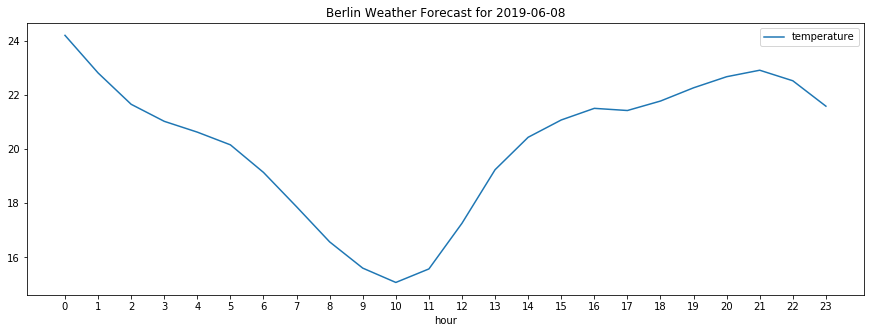

In [304]:
ax = plt.gca()
tomorrow_forecast.plot(kind='line',x='hour',y='temperature',title = 'Berlin Weather Forecast for ' + \
                       next_day_date, ax=ax,figsize=(15,5))
ax.set_xticks(range(len(tomorrow_forecast)));

<h4>  Further we could see tomorrow's forecast of important weather parameters on hour level </h4>

In [305]:
tomorrow_forecast_selected = tomorrow_forecast[['hour','summary', 'temperature','apparentTemperature',\
                                                'windSpeed']]

tomorrow_forecast_selected = tomorrow_forecast_selected.rename(columns= \
                             {'hour': 'Hour', 'summary': 'Forecast',\
                              'temperature':'Temperature (°C)', 'apparentTemperature': 'Feels Like (°C)',\
                              'windSpeed':'Wind Speed (m/s)'})

display(tomorrow_forecast_selected)

,Hour,Forecast,Temperature (°C),Feels Like (°C),Wind Speed (m/s)
0,0,Clear,24.21,24.21,4.05
1,1,Clear,22.82,22.82,4.43
2,2,Clear,21.66,21.66,4.66
3,3,Clear,21.03,21.03,4.59
4,4,Partly Cloudy,20.63,20.67,4.38
5,5,Partly Cloudy,20.16,20.23,4.37
6,6,Partly Cloudy,19.14,19.15,4.60
7,7,Clear,17.87,17.87,5.11
8,8,Clear,16.57,16.57,5.50
9,9,Clear,15.60,15.60,5.35


<h2> 3. KPIs for Atfarm </h2>

<h3>Marketing Metrics:</h3>

<br>

<b>Visitors: </b> Unique visitors visiting atfarm site during given period of time. Useful to track daily unique visitors, monthly unique visitors, average monthly visitors, monthly average of visitors per day.

<b> Visitors by traffic sources: </b> Where visitors are finding Atfarm (search, direct visit, referral, etc.,) ? understanding visit source is very important to enhance visibility and optimize the same. 

<b> Conversion Rate: </b> Out of all unique visitors how many actually signed up to use Atfarm. Total signups/total unique visitors. Further, it is also useful to get conversion rate by browser based and mobile app based

<b> Activation Rate: </b> Out of all users  who signed up and confirmed their email address during specific period, how many actually uploaded/provided field map details. Considering nature of Atfarm's business field data from our user is very important; it is of no use that user had just signup and what matters the most is to have relevant data from user so they are engaged to using the product. 
Further it would be interesting to track 1 day activation, 10 day activation, 1 month activation 

<b> Customer Acquisition Cost </b>:  Total marketing costs / Total customers acquired  for a given period of time. 

<b> Marketing Return on Investment (ROI): </b> (Sales Growth - Marketing Costs) / Marketing Costs

<b> App Downloads </b>: total app installs for a given period of time. It is also useful to track source of download to evaluate effectiveness of marketing efforts. 

<br>

<h3>Engagement Metrics:</h3>

<br>

<b> Average Application maps generated per farm account </b> - Average application maps generated per farm account for a given period of time. We could track this metric in different ways, for example, average monthly application maps generated.

<b> Average Application maps generated by farm role </b> - Average application maps generated per user(farm role) for a given period of time. This is useful to understand who is using the product more whether the admin or agronomist, driver, contractor, etc., 

<b> New Users added per farm account </b> - New users added/total farm accounts for a given period of time.

<b> Active Users </b> - Unique Users who generated atleast one application map for a given time period. Here we consider farm account.

<b> Average Daily Active Users (Monthly) </b> - total active users in a month / days in the month. Here we consider farm account.

<b> Session length </b> - time period between opening and closing of app/desktop. Longer the session duration more the engagement. 

<b> % active users using app </b> - out of all active users for a given period how many users also used their app to generate at least one application map. Here we consider farm account.

<b> time spent in app </b> - average number of minutes spent per day, per month for a given time period. This is useful to understand app engagement. Here we consider farm account. 

<b> Retention Rate </b> - how many users remained active?. Here we consider farm account. 
Retention rate = (Number of users at end of period – Number of users acquired during period) / # of users at start of period 

<b> Life Time Value </b> - useful to know how valuable a customer is in the long run. Simple way to calculate could be something like customer revenue minus the costs of acquiring and serving the customer.

<br>

<h3> Customer Service/Satisfaction Metrics:</h3>
<br>

Atfarm's business is all about farmers(customers). It is very important to provide high level of customer support and make sure customers are satisfied with offerings therefore it is important to track service metrics

<b> Help requests volume (from new users) </b> How many customer requests are coming from a new user in a given period. This refers to the requests from customers who had reached out to us through help center within their account. This could be because they are not able to find right information or needing help to add their maps, etc., 
Further it would also be useful to track help requests from new unactivated users (new user who did not upload field data) so we can help them with activation. 

This will help us to understand ease of use of Atfarm's platform if we receive too many requests then may be users are not able to find right information and this would provide us opportunity to understand how we can optimize the platform and make it more user friendly.

<b> Help requests volume (All users) </b> similar to above but we track all requests not just those from new users.

<b> Resolution Rate: </b> Out of all the help requests received from users during specific period of time, how many did we actually resolve?

<b> Average Response Time </b>: On average how long it takes for customer service team to respond to each customer request 

<b> Average Time to Resolution </b>: How long it takes for customer service team to resolve issues or requests made through help center. 